# Load raster data via WMS

In [1]:
from datetime import datetime

import matplotlib.pyplot as plt
import pandas as pd

import geoengine as ge

## Initialize Geo Engine

In [2]:
ge.initialize("http://localhost:3030/api")

In [3]:
session = ge.get_session()
session

Server:              http://localhost:3030/api
User Id:             72a99ea6-64a6-44f6-bb0c-07a3111bee2b
Session Id:          5cc5c92c-cad3-4d0c-954e-c35e6ff4cfcd
Session valid until: 2025-09-11T09:17:44.526Z

## Define workflow of Natural Earth 10m Ports

In [4]:
workflow = ge.register_workflow(
    {
        "type": "Vector",
        "operator": {"type": "OgrSource", "params": {"data": "ne_10m_ports", "attributeProjection": None}},
    }
)

workflow

2527ba30-375e-55d0-a54f-675ff6c21e71

## Define a query rectangle

In [ ]:
time_start = datetime.strptime("2014-04-01T12:00:00.000Z", "%Y-%m-%dT%H:%M:%S.%f%z")
time_end = datetime.strptime("2014-06-01T12:00:00.000Z", "%Y-%m-%dT%H:%M:%S.%f%z")
bbox = ge.QueryRectangle(ge.BoundingBox2D(-180.0, -90.0, 180.0, 90.0), ge.TimeInterval(time_start, time_end))

## Query dataset asynchronously

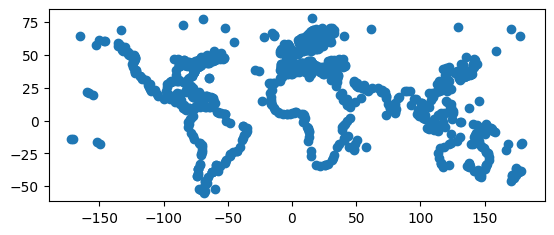

,featurecla,name,website,scalerank,natlscale,geometry,time_start,time_end
0,Port,Sint Nicolaas,www.rocargo.com/SanNicolas.html,8,5.0,MULTIPOINT ((-69.92356 12.4375)),NaT,NaT
1,Port,Campana,www.consejoportuario.com.ar,8,5.0,MULTIPOINT ((-58.95141 -34.15333)),NaT,NaT
2,Port,Zarate,www.consejoportuario.com.ar,8,5.0,MULTIPOINT ((-59.00495 -34.09889)),NaT,NaT
3,Port,Puerto Belgrano/Bahia Blanca,None,8,5.0,MULTIPOINT ((-62.10088 -38.89444)),NaT,NaT
4,Port,Puerto Galvan/Bahia Blanca,None,8,5.0,MULTIPOINT ((-62.30053 -38.78306)),NaT,NaT


In [6]:
async for data_frame in workflow.vector_stream(bbox):
    data_frame.plot()
    plt.show()
    display(data_frame.head())

## Query multiple batches of data

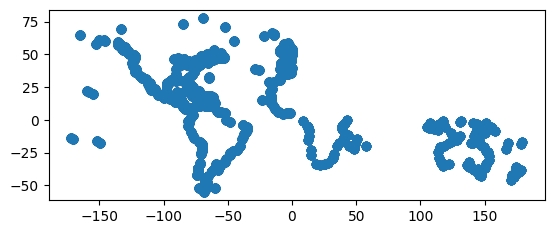

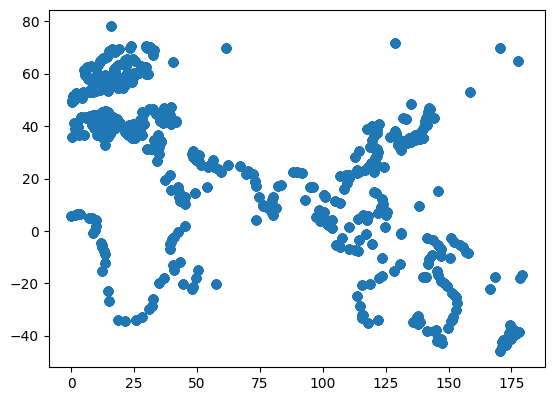

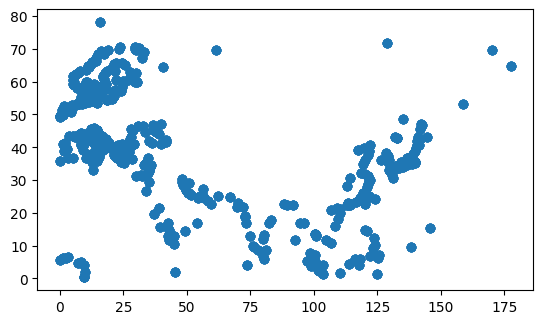

In [7]:
# we create a large data frame by repeating the data frame 160 times…
large_data_frame = pd.concat(
    [
        *[data_frame[["geometry", "scalerank", "natlscale"]].cx[-180:0, -90:0] for _ in range(40)],
        *[data_frame[["geometry", "scalerank", "natlscale"]].cx[-180:0, 0:90] for _ in range(40)],
        *[data_frame[["geometry", "scalerank", "natlscale"]].cx[0:180, -90:0] for _ in range(40)],
        *[data_frame[["geometry", "scalerank", "natlscale"]].cx[0:180, 0:90] for _ in range(40)],
    ],
    ignore_index=True,
)

# …then we upload it to the server…

new_id = ge.upload_dataframe(large_data_frame)

new_workflow = ge.register_workflow(
    {"type": "Vector", "operator": {"type": "OgrSource", "params": {"data": str(new_id), "attributeProjection": None}}}
)

# …and finally we can stream multiple batches from the server

async for chunk_data_frame in new_workflow.vector_stream(bbox):
    chunk_data_frame.plot()
    plt.show()

## Auto-merge into one geo data frame

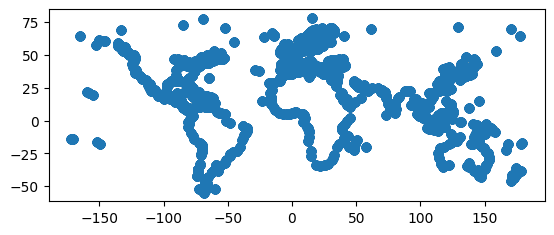

In [8]:
merged_data_frame = await new_workflow.vector_stream_into_geopandas(bbox)
merged_data_frame.plot()
plt.show()